<a href="https://colab.research.google.com/github/masaupa/TFM_UtielMaria/blob/main/TFM_UtielMaria(brujas).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En primer lugar, se descargan las bibliotecas y herramientas necesarias para realizar los siguientes pasos del análisis

In [26]:
!pip install gutenbergpy
!pip install nltk
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
import gutenbergpy.textget
import re
import os
import pandas as pd
import requests
import nltk
import matplotlib.pyplot as plt
import spacy
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from spacy import displacy
from spacy.matcher import PhraseMatcher
from gutenbergpy.gutenbergcache import GutenbergCache

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
nlp = spacy.load('en_core_web_lg')

#Obtención del corpus

In [29]:
def get_book(book_id):
    raw_book = gutenbergpy.textget.get_text_by_id(book_id)
    return raw_book.decode().strip()

book_id = {
    "The Wonderful Wizard of Oz": 55,
    "Grimm's Fairytales": 2591,
    "The Sociable Sand Witch": 68352
}

book_data = []
for title, id in book_id.items():
    text = get_book(id)
    book_data.append({'title': title, 'text': text})

df = pd.DataFrame(book_data)

def clean_text(text):
  text = text.lower()
  return text


df['clean_text'] = df['text'].apply(clean_text)

In [30]:
print(df[['title', 'clean_text']].head())

                        title  \
0  The Wonderful Wizard of Oz   
1          Grimm's Fairytales   
2     The Sociable Sand Witch   

                                          clean_text  
0  the project gutenberg ebook of the wonderful w...  
1  the project gutenberg ebook of grimms’ fairy t...  
2  the project gutenberg ebook of the sociable sa...  


In [31]:
def count_tokens(text):
    doc = nlp(text)
    num_tokens = len([token for token in doc if not token.is_space])
    return num_tokens

df['num_tokens'] = df['clean_text'].apply(count_tokens) 

num_tokens_total = df['num_tokens'].sum()
print(f"\nNúmero total de tokens: {num_tokens_total}")

num_tokens_fila_0 = df['num_tokens'].iloc[0]
print(f"\nNúmero de tokens de 'The Wonderful Wizard of Oz': {num_tokens_fila_0}")

num_tokens_fila_1 = df['num_tokens'].iloc[1]
print(f"\nNúmero de tokens de 'Grimm's Fairy Tales': {num_tokens_fila_1}")

num_tokens_fila_2 = df['num_tokens'].iloc[2]
print(f"\nNúmero de tokens de 'The Sociable Sand Witch': {num_tokens_fila_2}")


Número total de tokens: 224315

Número de tokens de 'The Wonderful Wizard of Oz': 51118

Número de tokens de 'Grimm's Fairy Tales': 126196

Número de tokens de 'The Sociable Sand Witch': 47001


#PRE-PROCESAMIENTO DEL CORPUS

In [32]:
def remove_newlines(text):
  return text.replace('\n', ' ')

In [33]:
def clean_text(text):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text)
  cleaned_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
  return ' '.join(cleaned_tokens)

In [34]:
df['clean_text'] = df['clean_text'].apply(remove_newlines)

print(df[['title', 'clean_text']].head())

                        title  \
0  The Wonderful Wizard of Oz   
1          Grimm's Fairytales   
2     The Sociable Sand Witch   

                                          clean_text  
0  the project gutenberg ebook of the wonderful w...  
1  the project gutenberg ebook of grimms’ fairy t...  
2  the project gutenberg ebook of the sociable sa...  


In [35]:
def get_sentences(text):
    return sent_tokenize(text)


data = []

In [36]:
bookd_id = {
    "The Wonderful Wizard of Oz": 55,
    "Grimm's Fairytales": 2591,
    "The Sociable Sand Witch": 68352
}

for title, gutenberg_id in bookd_id.items():
    try:
        text = get_book(gutenberg_id)
        if text:
            data.append((title, text))
        else:
            print(f"No se pudo obtener el texto del libro {title} (ID {gutenberg_id})")
    except Exception as e:
        print(f"Error al descargar el libro {title} (ID {gutenberg_id}): {e}")

df = pd.DataFrame(data, columns=['title', 'text'])

output_path = '/content/drive/MyDrive/text_files/dataset.csv'

os.makedirs(os.path.dirname(output_path), exist_ok=True)

df.to_csv(output_path, index=False, encoding='utf-8')

In [37]:
df.head()

,title,text
0,The Wonderful Wizard of Oz,The Project Gutenberg eBook of The Wonderful W...
1,Grimm's Fairytales,The Project Gutenberg eBook of Grimms’ Fairy T...
2,The Sociable Sand Witch,The Project Gutenberg eBook of The sociable Sa...


##INFO DATASET

In [38]:
def average_sentence_length(text):
    sentences = sent_tokenize(text)
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences) if sentences else 0

df['avg_sentence_length'] = df['text'].apply(average_sentence_length)

df[['title', 'avg_sentence_length']].head()

,title,avg_sentence_length
0,The Wonderful Wizard of Oz,24.536473
1,Grimm's Fairytales,35.637359
2,The Sociable Sand Witch,15.956559


In [39]:
def word_frequency(text, word):
    words = text.lower().split()
    word_count = words.count(word)
    total_words = len(words)
    return word_count / total_words if total_words > 0 else 0

print(word_frequency(text, 'witch'))

0.0006469177066767298


#SEPARAR CUENTOS DE GRIMM'S FAIRY TALES

In [40]:
grimm_fairytales = df.iloc[1]['text']

In [41]:
# Normalizar saltos de línea
grimm_fairytales_normalized = re.sub(r'\r\n|\r|\n', '\n', grimm_fairytales)

# Función para dividir "Grimm's Fairy Tales" en cuentos individuales
def extract_stories_from_grimm(grimm_text):
    # Ajustar para capturar títulos en mayúsculas, separados por al menos un salto de línea
    story_titles = re.findall(r'\n+([A-Z ]+)\n+', grimm_text)  # Buscar títulos en mayúsculas entre uno o más saltos de línea
    stories = re.split(r'\n+[A-Z ]+\n+', grimm_text)  # Dividir el texto usando esos títulos

    # Crear un diccionario con los cuentos y sus títulos
    stories_with_headers = {story_titles[i]: stories[i + 1].strip() for i in range(len(story_titles))}
    return stories_with_headers

# Dividir el texto normalizado
stories_with_headers = extract_stories_from_grimm(grimm_fairytales_normalized)

print("Cuentos extraídos:", list(stories_with_headers.keys()))


Cuentos extraídos: ['     THE GOLDEN BIRD', '     JORINDA AND JORINDEL', '     OLD SULTAN', '     BRIAR ROSE', '     THE TWELVE DANCING PRINCESSES', '     CAT AND MOUSE IN PARTNERSHIP', '     THE ADVENTURES OF CHANTICLEER AND PARTLET', '     RAPUNZEL', '     THE VALIANT LITTLE TAILOR', '     MOTHER HOLLE', '     THE ROBBER BRIDEGROOM', '     RUMPELSTILTSKIN', '     THE OLD MAN AND HIS GRANDSON', '     FREDERICK AND CATHERINE', '     SNOWDROP', '     CLEVER ELSIE', '     ASHPUTTEL', '     THE WOLF AND THE SEVEN LITTLE KIDS', '     THE ELVES AND THE SHOEMAKER', '     THE TURNIP', '     THE THREE LANGUAGES', '     THE FOUR CLEVER BROTHERS', '     THE FOX AND THE HORSE', '     THE RAVEN', '     THE WATER OF LIFE', '     THE KING OF THE GOLDEN MOUNTAIN', '     THE SEVEN RAVENS', '     FIRST STORY', '     THE SALAD', '     IRON HANS', 'THE BROTHERS GRIMM FAIRY TALES', 'HANS IN LUCK', 'JORINDA AND JORINDEL', 'THE TRAVELLING MUSICIANS', 'OLD SULTAN', 'BRIAR ROSE', 'THE DOG AND THE SPARROW', 'T

In [42]:
# Función para dividir "Grimm's Fairy Tales" en cuentos individuales, tolerando espacios extra
def extract_stories_from_grimm(grimm_text):
    story_titles = re.findall(r'\n+\s*([A-Z ]+)\s*\n+', grimm_text) 
    stories = re.split(r'\n+\s*[A-Z ]+\s*\n+', grimm_text)  # Dividir el texto usando esos títulos

    # Crear un diccionario con los cuentos y sus títulos
    stories_with_headers = {story_titles[i]: stories[i + 1].strip() for i in range(len(story_titles))}
    return stories_with_headers

# Dividir el texto de "Grimm's Fairy Tales" en cuentos individuales
stories_with_headers = extract_stories_from_grimm(grimm_fairytales)

print("Cuentos extraídos:", list(stories_with_headers.keys()))


Cuentos extraídos: ['THE GOLDEN BIRD', 'JORINDA AND JORINDEL', 'OLD SULTAN', 'BRIAR ROSE', 'THE TWELVE DANCING PRINCESSES', 'CAT AND MOUSE IN PARTNERSHIP', 'THE ADVENTURES OF CHANTICLEER AND PARTLET', 'RAPUNZEL', 'THE VALIANT LITTLE TAILOR', 'MOTHER HOLLE', 'THE ROBBER BRIDEGROOM', 'RUMPELSTILTSKIN', 'THE OLD MAN AND HIS GRANDSON', 'FREDERICK AND CATHERINE', 'SNOWDROP', 'CLEVER ELSIE', 'ASHPUTTEL', 'THE WOLF AND THE SEVEN LITTLE KIDS', 'THE ELVES AND THE SHOEMAKER', 'THE TURNIP', 'THE THREE LANGUAGES', 'THE FOUR CLEVER BROTHERS', 'THE FOX AND THE HORSE', 'THE RAVEN', 'THE WATER OF LIFE', 'THE KING OF THE GOLDEN MOUNTAIN', 'THE SEVEN RAVENS', 'FIRST STORY', 'THE SALAD', 'IRON HANS', 'THE BROTHERS GRIMM FAIRY TALES', 'HANS IN LUCK', 'THE TRAVELLING MUSICIANS', 'THE DOG AND THE SPARROW', 'THE FISHERMAN AND HIS WIFE', 'FUNDEVOGEL', 'HANSEL AND GRETEL', 'TOM THUMB', 'CLEVER GRETEL', 'THE LITTLE PEASANT', 'SWEETHEART ROLAND', 'THE PINK', 'THE MISER IN THE BUSH', 'THE WHITE SNAKE', 'THE QUEEN

In [43]:
output_directory = "/content/drive/MyDrive/TFM/cuentos_grimm"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)


for title, story_text in stories_with_headers.items():
    valid_title = "".join([c if c.isalnum() or c.isspace() else "_" for c in title])
    filename = os.path.join(output_directory, f"{valid_title}.txt")

    with open(filename, "w", encoding="utf-8") as file:
        file.write(story_text)

print(f"Todos los cuentos se han guardado en la carpeta '{output_directory}'")

Todos los cuentos se han guardado en la carpeta '/content/drive/MyDrive/TFM/cuentos_grimm'


#MAGO DE OZ

In [44]:
def analyze_characters_oz(text):
    doc = nlp(text)
    characters = [ent.text for ent in doc.ents if ent.label_ == "PERSON" and "ORG"]
    character_counts = Counter(characters)
    return character_counts

index_oz = df[df['title'] == "The Wonderful Wizard of Oz"].index[0]

print(analyze_characters_oz(df['text'][index_oz]))

Counter({'Dorothy': 345, 'Oz': 57, 'Project Gutenberg-tm': 37, 'Scarecrow': 28, 'Winkies': 23, 'Dorothy\r\n': 15, 'Glinda': 14, 'Uncle Henry': 10, 'Munchkins': 8, 'Cap': 6, 'Gayelette': 6, 'Boq': 5, 'Munchkin': 5, 'Aunt Em': 4, 'Project Gutenberg': 4, 'Woodman': 3, 'the Monkey King': 3, 'Joker': 3, 'L. Frank Baum': 2, 'the King of Beasts': 2, 'Mouse': 2, 'pep-pe': 2, 'Hil-lo': 2, 'hol-lo': 2, 'hel-lo': 2, 'the King of the Monkeys': 2, 'L. Frank Baum\r\n\r\n': 1, 'Dorothy Saved': 1, 'L. Frank Baum\r\nChicago': 1, 'Uncle\r\nHenry': 1, 'Henry\r\n': 1, 'Uncle Henry\r\n': 1, 'Toto\r\n': 1, 'gingham': 1, 'Munchkin maiden': 1, 'The King of Beasts': 1, 'Lion': 1, 'Meek': 1, 'Sorrowfully Dorothy': 1, 'the King Crow': 1, 'the Queen of the Mice': 1, 'the Tin Woodman': 1, 'the King of the Winged Monkeys': 1, 'Hush': 1, 'Wizard': 1, 'This\r\nhill': 1, 'Redistributing Project\r\nGutenberg-tm': 1, 'Project\r\nGutenberg-tm': 1, 'Project Gutenberg-': 1, "Project Gutenberg-tm's": 1, 'Michael S. Hart': 1

In [47]:
doc = nlp(df['text'][index_oz])
patron_bruja = re.compile(r"\b(Witch|Wicked Witch|Good Witch|North Witch)\b", re.IGNORECASE)

frases_bruja = []
for sent in doc.sents:
    if re.search(patron_bruja, sent.text):
        frases_bruja.append(sent.text)


df_frases_bruja = pd.DataFrame(frases_bruja, columns=["Frase"])

print(df_frases_bruja)

# Ejecutar dependency parsing en cada frase que menciona a la bruja
for i, frase in enumerate(frases_bruja):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase = nlp(frase)
    for token in doc_frase:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

Se han truncado las últimas 5000 líneas del flujo de salida.
, (punct) <-- country
where (advmod) <-- live
the (det) <-- Winkies
Winkies (nsubj) <-- live
live (relcl) <-- country
, (punct) <-- country
is (auxpass) <-- ruled
ruled (ccomp) <-- said
by (agent) <-- ruled
the (det) <-- Witch
Wicked (compound) <-- Witch
Witch (pobj) <-- by
of (prep) <-- Witch

 (dep) <-- of
the (det) <-- West
West (pobj) <-- of
, (punct) <-- West
who (nsubj) <-- make
would (aux) <-- make
make (relcl) <-- Witch
you (nsubj) <-- slave
her (poss) <-- slave
slave (ccomp) <-- make
if (mark) <-- passed
you (nsubj) <-- passed
passed (advcl) <-- make
her (poss) <-- way
way (dobj) <-- passed
. (punct) <-- ruled
” (punct) <-- ruled


 (dep) <-- ”
“ (punct) <-- said
The (det) <-- North
North (nsubj) <-- is
is (ccomp) <-- said
my (poss) <-- home
home (attr) <-- is
, (punct) <-- said
” (punct) <-- said
said (ROOT) <-- said
the (det) <-- lady
old (amod) <-- lady
lady (nsubj) <-- said
, (punct) <-- lady
“ (punct) <-- said
a

In [48]:
json_filename = "/content/drive/MyDrive/frases_bruja.json"
df_frases_bruja.to_json(json_filename, index=False)

In [49]:
output_dir = "/content/drive/MyDrive/TFM"

frases_bruja_oz = [
  "'But I thought all witches were wicked' said the girl, who was half frightened at facing a real witch",
  "Those who dwelt in the East and the West were, indeed, wicked withces; but now that you have killed one of them, there is but one Wicked Withc in all the Land of Oz-the one who lives in the West",
  "that country, where the Winkies live, is ruled by the Wicked Witch of the West, who would make you her salve if you passed her way",
  "The Witch gave Dorothy a friendly little nod, whirled around on her left heel three times, and straightaway disappeared, much to the surprise of little Toto, who barked after her loudly enough when se had gone, because he had been afraid even to growl while she stood by",
  "One in a while she would pass a house, and the people came out to look at her and bow low as she went by; for everyone knew she had been the means of destroying the Wicked Witch and setting them free from bondage",
  "The people greeted Dorothy kindly, and invited her to supper and to pass the night with them; for this was the home of one of the richest Munchkins in the land, and his friends were gathered with him to celebrate their freedom from the bondage of the Wicked Witch",
  "So we know you are a friendly witch",
  "'I thought I had beaten the Wicked Witch then, and I worked harder than ever; but I little knew how cruel my enemy could be'",
  "But I am not afraid so long as I have my oil-can, and nothing can hurt the Scarecrow, while you bear upon your forehead the mark of the Good Witch's kiss, and that will protect you from harm",
  "Remember that the Witch is Wicked-tremendously Wicked-and ought to be killed",
  "Now the Wicked Witch of the West had but one eye, yet that was as powerful as a telescope, and could see everywhere",
  "But she was a powerful Witch, as well as a wicked one"

]


for i, frase in enumerate(frases_bruja_oz):
    print(f"Guardando visualización de dependencias para la frase {i+1}: {frase}")
    doc_frase = nlp(frase)

    svg = displacy.render(doc_frase, style='dep', jupyter=False, options={'distance': 110})


    file_path = os.path.join(output_dir, f"frase_bruja_{i+1}.svg")

    with open(file_path, "w", encoding="utf-8") as file:
        file.write(svg)


Guardando visualización de dependencias para la frase 1: 'But I thought all witches were wicked' said the girl, who was half frightened at facing a real witch
Guardando visualización de dependencias para la frase 2: Those who dwelt in the East and the West were, indeed, wicked withces; but now that you have killed one of them, there is but one Wicked Withc in all the Land of Oz-the one who lives in the West
Guardando visualización de dependencias para la frase 3: that country, where the Winkies live, is ruled by the Wicked Witch of the West, who would make you her salve if you passed her way
Guardando visualización de dependencias para la frase 4: The Witch gave Dorothy a friendly little nod, whirled around on her left heel three times, and straightaway disappeared, much to the surprise of little Toto, who barked after her loudly enough when se had gone, because he had been afraid even to growl while she stood by
Guardando visualización de dependencias para la frase 5: One in a while s

In [50]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sentiment_scores = []
for frase in frases_bruja_oz:
  sentiment = analyze_sentiment(frase)
  sentiment_scores.append(sentiment)

df_frases_bruja_oz = pd.DataFrame({'Frase': frases_bruja_oz, 'Sentimiento': sentiment_scores})
print(df_frases_bruja_oz)


                                                Frase  Sentimiento
0   'But I thought all witches were wicked' said t...     0.016667
1   Those who dwelt in the East and the West were,...    -0.200000
2   that country, where the Winkies live, is ruled...     0.136364
3   The Witch gave Dorothy a friendly little nod, ...    -0.057143
4   One in a while she would pass a house, and the...     0.066667
5   The people greeted Dorothy kindly, and invited...     0.600000
6                 So we know you are a friendly witch     0.375000
7   'I thought I had beaten the Wicked Witch then,...    -0.429167
8   But I am not afraid so long as I have my oil-c...     0.316667
9   Remember that the Witch is Wicked-tremendously...    -0.200000
10  Now the Wicked Witch of the West had but one e...     0.300000
11  But she was a powerful Witch, as well as a wic...     0.300000


In [51]:
adjetivos_bruja_oz = []

for frase in df_frases_bruja_oz["Frase"]:
    doc_frase = nlp(frase)
    adjetivos_en_frase = [token.text for token in doc_frase if token.pos_ == "ADJ"]
    adjetivos_bruja_oz.append(", ".join(adjetivos_en_frase))

df_frases_bruja_oz["Adjetivos"] = adjetivos_bruja_oz

print(df_frases_bruja_oz)

                                                Frase  Sentimiento  \
0   'But I thought all witches were wicked' said t...     0.016667   
1   Those who dwelt in the East and the West were,...    -0.200000   
2   that country, where the Winkies live, is ruled...     0.136364   
3   The Witch gave Dorothy a friendly little nod, ...    -0.057143   
4   One in a while she would pass a house, and the...     0.066667   
5   The people greeted Dorothy kindly, and invited...     0.600000   
6                 So we know you are a friendly witch     0.375000   
7   'I thought I had beaten the Wicked Witch then,...    -0.429167   
8   But I am not afraid so long as I have my oil-c...     0.316667   
9   Remember that the Witch is Wicked-tremendously...    -0.200000   
10  Now the Wicked Witch of the West had but one e...     0.300000   
11  But she was a powerful Witch, as well as a wic...     0.300000   

                                 Adjetivos  
0                 wicked, frightened, real  

In [59]:
import glob
import json
directorio = '/content/drive/MyDrive/Archivo/oz'

archivos_json = glob.glob(os.path.join(directorio, '*.json'))

for archivo in archivos_json:
    with open(archivo, 'r') as f:
        contenido = f.read()
        print(f"Contenido del archivo {archivo}:\n")
        print(contenido[:100])
        print("\n" + "="*80 + "\n")

directorio = '/content/drive/MyDrive/Archivo/oz/'

archivos_json = glob.glob(os.path.join(directorio, '*.json'))

# Lista para almacenar los promedios por capítulo
promedios_por_capitulo = []

adjetivos_valores = {
    "helpful": 0, "charismatic": 0, "intelligent": 0, "powerful": 0, "resourceful": 0, "kind": 0, "brilliant": 0, "grateful": 0, "good": 0, "friendly": 0, "fierce": 0, "cunning": 0, "manipulative": 0, "greedy": 0, "deceiptive": 0, "cruel": 0, "selfish": 0, "wicked": 0,
    "fearful": 0, "proud": 0
}

for archivo in archivos_json:
    with open(archivo, 'r') as f:
        data = json.load(f)

        if "The Wicked Witch of the West" in data:
            caracteristicas = data["The Wicked Witch of the West"]

            # Obtener los adjetivos positivos y negativos
            adjetivos = caracteristicas.get("positive", []) + caracteristicas.get("negative", [])

            # Calcular la puntuación promedio usando el diccionario de valores
            valores = [adjetivos_valores.get(adj.lower(), 0) for adj in adjetivos]
            if valores:
                promedio = sum(valores) / len(valores)
                promedios_por_capitulo.append(promedio)
            else:
                promedios_por_capitulo.append(0) 

print(promedios_por_capitulo)


Contenido del archivo /content/drive/MyDrive/Archivo/oz/Chapter XI The Wonderful City of Oz_characterization.json:

{"The Wicked Witch of the East": {"positive": ["kind", "polite", "generous"], "negative": ["wicked",


Contenido del archivo /content/drive/MyDrive/Archivo/oz/Chapter XVI The Magic Art of the Great Humbug_characterization.json:

{"Oz": {"positive": ["kind", "grateful", "proud", "wise"], "negative": ["humbug", "cruel", "uneasy"]


Contenido del archivo /content/drive/MyDrive/Archivo/oz/Chapter XXII The Country of the Quadlings_characterization.json:

{"The Scarecrow": {"positive": ["brave", "bold", "determined"], "negative": ["reckless", "overconfid


Contenido del archivo /content/drive/MyDrive/Archivo/oz/Chapter X The Guardian of the Gate_characterization.json:

{"The Great Oz": {"positive": ["powerful", "wise", "generous", "good"], "negative": ["terrible", "pr


Contenido del archivo /content/drive/MyDrive/Archivo/oz/Chapter XVII How the Balloon Was Launched_characteriz

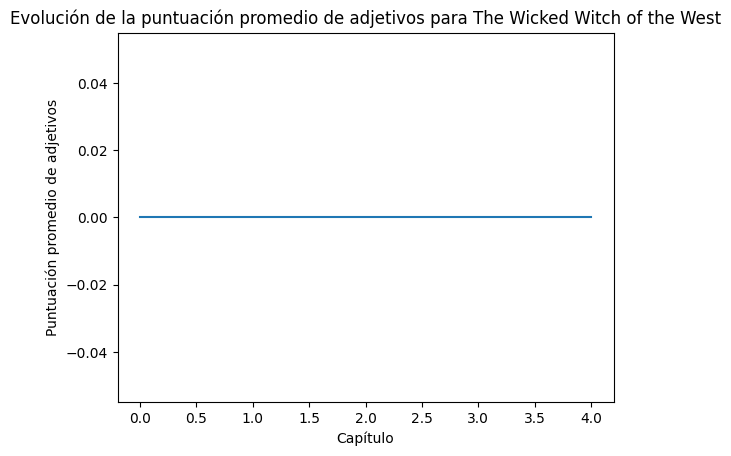

In [60]:


import matplotlib.pyplot as plt

plt.plot(promedios_por_capitulo)
plt.xlabel('Capítulo')
plt.ylabel('Puntuación promedio de adjetivos')
plt.title('Evolución de la puntuación promedio de adjetivos para The Wicked Witch of the West')
plt.show()


##Análisis del mago

In [26]:
patron_mago = re.compile(r"\b(Wizard|Wizard of Oz)\b", re.IGNORECASE)

frases_mago = []
for sent in doc.sents:
    if re.search(patron_mago, sent.text):
        frases_mago.append(sent.text)


df_frases_mago = pd.DataFrame(frases_mago, columns=["Frase"])

print(df_frases_mago)

# Ejecutar dependency parsing en cada frase que menciona a la bruja
for i, frase in enumerate(frases_mago):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase = nlp(frase)
    for token in doc_frase:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                                Frase
0   The Project Gutenberg eBook of The Wonderful W...
1   Title: The Wonderful Wizard of Oz\r\n\r\nAutho...
2   [eBook #55]\r\n[Most recently updated: October...
3   **\r\n\r\n[Illustration]\r\n\r\n\r\n\r\n\r\nTh...
4   Having this thought in mind, the story of “The...
5   The Wonderful Wizard of Oz\r\n\r\n\r\n\r\n\r\n...
6   “Oz himself is the Great Wizard,” answered the...
7   “It is exactly in the center of the country, a...
8                               “He is a good Wizard.
9   So they found a cozy place under the trees whe...
10  “You see, Oz is a\r\nGreat Wizard, and can tak...
11  But first you must get to see him, and that wi...
12  “He is powerful and terrible, and if\r\nyou co...
13  And we have been told that Oz is a good\r\nWiz...
14  The Guardian of the Gates led them through the...
15  As Dorothy entered they looked at her curiousl...
16  “Because you are strong and I am weak; because...
17  The Scarecrow went sorro

In [27]:
frases_mago_seleccionadas = [
    "'Oz himself is the Great Wizard', answered the Witch",
    "You see, Oz is a Great Wizard, and can take on any form he wishes.",
    "He is a good wizard",
    "And Dorothy dreamed of the Emerald City, and of the good Wizard Oz, who would soon send her back to her own home again.",
    "And we have been told that Oz is a good Wizard.",
    "For the Great Wizard does not like to see anyone, and he usually has his own way",
    "The Guardian of the Gates led them through the streets until they came to a big building, exactly in the middle of the City, which was the Palace of Oz, the Great Wizard.",
    "He is powerful and terrible, and if you come on an idle or foolish errand to bother the wise reflexionst of the Great Wizard, he might be angry",
    "Because you are strong and I am weak; because you are a Great Wizard and I am only a little girl",
    "As for the Ball of Fire, the false Wizard had hung that also from the ceiling",
    "Oh, no, my dear; I'm really a very good man, but I'm a very bad Wizard, I must admit.",
    "And that was the last any of them ever saw of Oz, the Wonderful Wizard, though he may have reached Omaha safely"

]

def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sentiment_scores = []
for frase in frases_mago_seleccionadas:
  sentiment = analyze_sentiment(frase)
  sentiment_scores.append(sentiment)

max_score = max(sentiment_scores)
min_score = min(sentiment_scores)

# Comprobar si hay valores que necesitan ser normalizados
normalized_scores = [
    (score - min_score) / (max_score - min_score) * 2 - 1 if max_score != min_score else 0
    for score in sentiment_scores
]

# Crear DataFrame
df_frases_mago_oz_seleccionadas = pd.DataFrame({
    'Frase': frases_mago_seleccionadas,
    'Sentimiento': normalized_scores
})

print(df_frases_mago_oz_seleccionadas)


                                                Frase  Sentimiento
0   'Oz himself is the Great Wizard', answered the...     1.000000
1   You see, Oz is a Great Wizard, and can take on...     1.000000
2                                 He is a good wizard     0.833333
3   And Dorothy dreamed of the Emerald City, and o...     0.388889
4     And we have been told that Oz is a good Wizard.     0.833333
5   For the Great Wizard does not like to see anyo...     0.305556
6   The Guardian of the Gates led them through the...     0.104167
7   He is powerful and terrible, and if you come o...    -0.233333
8   Because you are strong and I am weak; because ...    -0.109722
9   As for the Ball of Fire, the false Wizard had ...    -1.000000
10  Oh, no, my dear; I'm really a very good man, b...    -0.333333
11  And that was the last any of them ever saw of ...     0.500000


In [133]:
adjetivos_mago_oz = []

for frases in df_frases_mago_oz_seleccionadas["Frase"]:
    doc_frase = nlp(frases)
    adjetivos_en_frase = [token.text for token in doc_frase if token.pos_ == "ADJ"]
    adjetivos_mago_oz.append(", ".join(adjetivos_en_frase))

df_frases_mago_oz_seleccionadas["Adjetivos"] = adjetivos_mago_oz

print(df_frases_mago_oz_seleccionadas)

                                                Frase  Sentimiento  \
0   'Oz himself is the Great Wizard', answered the...     1.000000   
1   You see, Oz is a Great Wizard, and can take on...     1.000000   
2                                 He is a good wizard     0.833333   
3   And Dorothy dreamed of the Emerald City, and o...     0.388889   
4     And we have been told that Oz is a good Wizard.     0.833333   
5   For the Great Wizard does not like to see anyo...     0.305556   
6   The Guardian of the Gates led them through the...     0.104167   
7   He is powerful and terrible, and if you come o...    -0.233333   
8   Because you are strong and I am weak; because ...    -0.109722   
9   As for the Ball of Fire, the false Wizard had ...    -1.000000   
10  Oh, no, my dear; I'm really a very good man, b...    -0.333333   
11  And that was the last any of them ever saw of ...     0.500000   

                                         Adjetivos  
0                                   

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

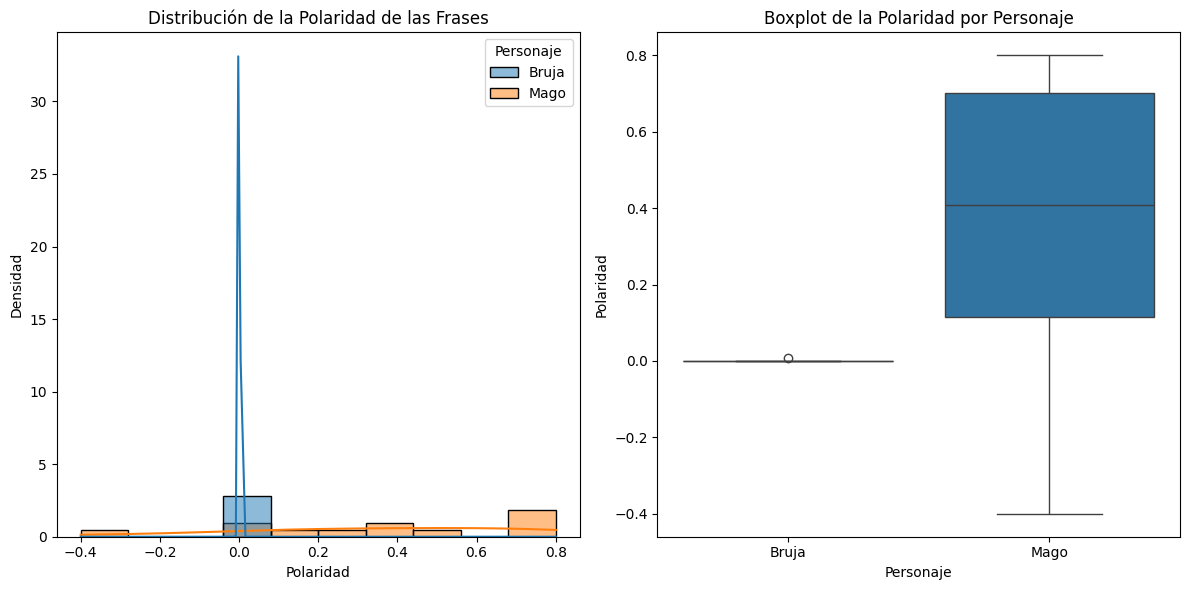

In [28]:

frases_bruja = [
    "I'll get you, my pretty, and your little dog too!",
    "You have no power here! Begone, before somebody drops a house on you!",
    "I am the Wicked Witch of the West!",
    "I’ll show you how to defeat the Wizard!",
    "You’re not in Kansas anymore, you know.",
    "I have the power to make you disappear!"
]

frases_mago = [
    "'Oz himself is the Great Wizard', answered the Witch",
    "You see, Oz is a Great Wizard, and can take on any form he wishes.",
    "He is a good wizard",
    "And Dorothy dreamed of the Emerald City, and of the good Wizard Oz, who would soon send her back to her own home again.",
    "And we have been told that Oz is a good Wizard.",
    "For the Great Wizard does not like to see anyone, and he usually has his own way",
    "The Guardian of the Gates led them through the streets until they came to a big building, exactly in the middle of the City, which was the Palace of Oz, the Great Wizard.",
    "He is powerful and terrible, and if you come on an idle or foolish errand to bother the wise reflexionst of the Great Wizard, he might be angry",
    "Because you are strong and I am weak; because you are a Great Wizard and I am only a little girl",
    "As for the Ball of Fire, the false Wizard had hung that also from the ceiling",
    "Oh, no, my dear; I'm really a very good man, but I'm a very bad Wizard, I must admit.",
    "And that was the last any of them ever saw of Oz, the Wonderful Wizard, though he may have reached Omaha safely"
]

# Función para analizar el sentimiento
def analyze_sentiment(frases):
    return [TextBlob(frase).sentiment.polarity for frase in frases]

# Calcular la polaridad
polaridad_bruja = analyze_sentiment(frases_bruja)
polaridad_mago = analyze_sentiment(frases_mago)

# Crear DataFrame para la visualización
df = pd.DataFrame({
    'Frase': frases_bruja + frases_mago,
    'Polaridad': polaridad_bruja + polaridad_mago,
    'Personaje': ['Bruja'] * len(frases_bruja) + ['Mago'] * len(frases_mago)
})

# Configuración de la figura
plt.figure(figsize=(12, 6))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df, x='Polaridad', hue='Personaje', kde=True, bins=10, stat='density')
plt.title('Distribución de la Polaridad de las Frases')
plt.xlabel('Polaridad')
plt.ylabel('Densidad')


plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Personaje', y='Polaridad')
plt.title('Boxplot de la Polaridad por Personaje')
plt.ylabel('Polaridad')

plt.tight_layout()
plt.show()


#GRIMM'S FAIRYTALES

In [29]:
def extract_stories_with_headers(text, titles):
    titles = [title.lower() for title in titles]
    lines = text.split('\n')
    stories = {}
    current_title = None
    current_story = []

    for line in lines:
        line_lower = line.strip().lower()
        if line_lower in titles:
            if current_title and current_story:
                stories[current_title] = ' '.join(current_story)
            current_title = line.strip()
            current_story = []
            print(f"Found title: {line}")
        elif current_title:
            current_story.append(line.strip())

    if current_title and current_story:
        stories[current_title] = ' '.join(current_story)

    return stories

titles = [
    "Jorinda and Jorindel",
    "Hansel and Gretel",
    "The Robber Bridegroom",
    "Sweetheart Roland",
    "The Pink",
    "The Raven"
]

stories_with_headers = extract_stories_with_headers(get_book(2591), titles)

df_stories = pd.DataFrame(list(stories_with_headers.items()), columns=['Cuento', 'Texto'])

for title, story in stories_with_headers.items():
    print(f"{title} - Longitud: {len(story)} caracteres")
    print(f"{story[:500]}...\n")


Found title:      JORINDA AND JORINDEL
Found title:      HANSEL AND GRETEL
Found title:      THE ROBBER BRIDEGROOM
Found title:      SWEETHEART ROLAND
Found title:      THE PINK
Found title:      THE RAVEN
Found title: JORINDA AND JORINDEL
Found title: HANSEL AND GRETEL
Found title: THE ROBBER BRIDEGROOM
Found title: SWEETHEART ROLAND
Found title: THE PINK
Found title: THE RAVEN
JORINDA AND JORINDEL - Longitud: 120252 caracteres
  There was once an old castle, that stood in the middle of a deep gloomy wood, and in the castle lived an old fairy. Now this fairy could take any shape she pleased. All the day long she flew about in the form of an owl, or crept about the country like a cat; but at night she always became an old woman again. When any young man came within a hundred paces of her castle, he became quite fixed, and could not move a step till she came and set him free; which she would not do till he had given her ...

HANSEL AND GRETEL - Longitud: 33017 caracteres
  Hard by a gre

In [30]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]


data = []


for index, row in df_stories.iterrows():
    cuento = row['Cuento']
    texto = row['Texto']

    entidades = extract_entities(texto)

    for entidad in entidades:
        data.append((cuento, entidad[0], entidad[1]))

df_entidades = pd.DataFrame(data, columns=['Cuento', 'Entidad', 'Tipo'])

csv_filename = "/content/drive/MyDrive/entidades_cuentos_grimm_1.csv"
df_entidades.to_csv(csv_filename, index=False)

print(df_entidades.head(50))

                  Cuento        Entidad    Tipo
0   JORINDA AND JORINDEL       Jorindel  PERSON
1   JORINDA AND JORINDEL       Jorindel  PERSON
2   JORINDA AND JORINDEL       Jorindel  PERSON
3   JORINDA AND JORINDEL       Jorindel  PERSON
4   JORINDA AND JORINDEL       Jorindel  PERSON
5   JORINDA AND JORINDEL            ‘Tu  PERSON
6   JORINDA AND JORINDEL         Tu whu  PERSON
7   JORINDA AND JORINDEL         Tu whu  PERSON
8   JORINDA AND JORINDEL       Jorindel  PERSON
9   JORINDA AND JORINDEL           bush  PERSON
10  JORINDA AND JORINDEL       Jorindel  PERSON
11  JORINDA AND JORINDEL       Jorindel  PERSON
12  JORINDA AND JORINDEL        Jorinda  PERSON
13  JORINDA AND JORINDEL       Jorindel  PERSON
14  JORINDA AND JORINDEL       Jorindel  PERSON
15  JORINDA AND JORINDEL    Chanticleer  PERSON
16  JORINDA AND JORINDEL           cock  PERSON
17  JORINDA AND JORINDEL    Chanticleer  PERSON
18  JORINDA AND JORINDEL         Donkey  PERSON
19  JORINDA AND JORINDEL    Chanticleer 

In [31]:
entidades_interes_grimm = ["Witch", "Gothel", "Old lady"]

entidades_interes_grimm = [ent for ent in doc.ents if any(e in ent.text for e in entidades_interes_grimm)]

adjetivos_entidades_grimm = {}
for ent in entidades_interes_grimm:
    adjetivos = []
    for token in doc:
        if token.pos_ == "ADJ":
            if token.head == ent.root or token.head.head == ent.root or token.head in ent.root.subtree:
                adjetivos.append(token.text)
    if adjetivos:
        adjetivos_entidades_grimm[ent.text] = adjetivos

In [32]:
rows = []
for entidad, adjetivos in adjetivos_entidades_grimm.items():
    entidad_tipo = next(ent.label_ for ent in doc.ents if ent.text == entidad)
    rows.append((entidad, entidad_tipo, ', '.join(adjetivos))) 

# Crear DataFrame usando pandas
grimm_df = pd.DataFrame(rows, columns=['Entidad', 'Tipo', 'Adjetivos'])

# Guardar el DataFrame en un archivo CSV
csv_filename = "/content/drive/MyDrive/entidades_adjetivos_filtrados.csv"
df.to_csv(csv_filename, index=False)

In [33]:
patron_bruja_grimm = re.compile(r"\b(Old lady|Witch|Gothel|Old Woman)\b", re.IGNORECASE)

frases_bruja_grimm = [df_stories]
for sent in doc.sents:
    if re.search(patron_bruja, sent.text):
        frases_bruja.append(sent.text)


df_frases_bruja = pd.DataFrame(frases_bruja, columns=["Frase"])

print(df_frases_bruja)

                                                 Frase
0    I'll get you, my pretty, and your little dog too!
1    You have no power here! Begone, before somebod...
2                   I am the Wicked Witch of the West!
3              I’ll show you how to defeat the Wizard!
4              You’re not in Kansas anymore, you know.
..                                                 ...
128  Dorothy then gave her the Golden Cap, and the ...
129  Then he said, “The Winkies\r\nwere very kind t...
130  Then the Witch looked at the big, shaggy Lion ...
131  Then, having used up the powers of the Golden\...
132  But now that each of them has had what he most...

[133 rows x 1 columns]


In [34]:
cuentos = [
    "Jorinda and Jorindel",
    "Hansel and Gretel",
    "The Robber Bridegroom",
    "Sweetheart Roland",
    "The Pink",
    "The Raven"
]

todos_los_resultados = []


for idx, cuento in enumerate(cuentos):
  doc = nlp(cuento)


  adjetivos_entidades_grimm = {}
  for token in doc:
      if token.pos_ == "ADJ":
          for ent in doc.ents:
              if token.head == ent.root or token.head.head == ent.root:
                if ent.text in adjetivos_entidades_grimm:
                    adjetivos_entidades_grimm[ent.text].append(token.text)
                else:
                    adjetivos_entidades_grimm[ent.text] = [token.text]

  rows = []
  for entidad, adjetivos in adjetivos_entidades_grimm.items():
      entidad_tipo = next(ent.label_ for ent in doc.ents if ent.text == entidad)
      rows.append((entidad, entidad_tipo, ', '.join(adjetivos), f'Cuento{idx+1}'))

  todos_los_resultados.extend(rows)

grimm_df = pd.DataFrame(rows, columns=['Entidad', 'Tipo', 'Adjetivos', 'Cuento'])

print(grimm_df)

Empty DataFrame
Columns: [Entidad, Tipo, Adjetivos, Cuento]
Index: []


In [35]:
def split_text_into_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

data = []

for index, row in df_stories.iterrows():
    cuento = row['Cuento']
    texto = row['Texto']

    frases = split_text_into_sentences(texto)


    for frase in frases:
        data.append((cuento, frase))


df_frases = pd.DataFrame(data, columns=['Cuento', 'Frase'])

csv_filename = "/content/drive/MyDrive/frases_cuentos_grimm.csv"
df_frases.to_csv(csv_filename, index=False)


print(df_frases.head(100))


                  Cuento                                              Frase
0   JORINDA AND JORINDEL                                                   
1   JORINDA AND JORINDEL  There was once an old castle, that stood in th...
2   JORINDA AND JORINDEL   Now this fairy could take any shape she pleased.
3   JORINDA AND JORINDEL  All the day long she flew about in the form of...
4   JORINDA AND JORINDEL  When any young man came within a hundred paces...
..                   ...                                                ...
95  JORINDA AND JORINDEL  At this the robber ran back as fast as he coul...
96  JORINDA AND JORINDEL  After this the robbers never dared to go back ...
97  JORINDA AND JORINDEL                                         OLD SULTAN
98  JORINDA AND JORINDEL  A shepherd had a faithful dog, called Sultan, ...
99  JORINDA AND JORINDEL  And one day when the shepherd and his wife wer...

[100 rows x 2 columns]


##HANSEL Y GRETEL

In [37]:
ruta_hansel = '/content/drive/MyDrive/TFM/cuentos_grimm/HANSEL AND GRETEL.txt'
with open(ruta_hansel, 'r', encoding='utf-8') as archivo:
    texto_hansel = archivo.read()
    print(texto_hansel)

Hard by a great forest dwelt a poor wood-cutter with his wife and his
two children. The boy was called Hansel and the girl Gretel. He had
little to bite and to break, and once when great dearth fell on the
land, he could no longer procure even daily bread. Now when he thought
over this by night in his bed, and tossed about in his anxiety, he
groaned and said to his wife: ‘What is to become of us? How are we
to feed our poor children, when we no longer have anything even for
ourselves?’ ‘I’ll tell you what, husband,’ answered the woman, ‘early
tomorrow morning we will take the children out into the forest to where
it is the thickest; there we will light a fire for them, and give each
of them one more piece of bread, and then we will go to our work and
leave them alone. They will not find the way home again, and we shall be
rid of them.’ ‘No, wife,’ said the man, ‘I will not do that; how can I
bear to leave my children alone in the forest?--the wild animals would
soon come and tear them 

In [61]:
doc_hansel = nlp(texto_hansel)

entidades_hansel = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]

df_entidades_hansel = pd.DataFrame(entidades_hansel, columns=['Entidad', 'Tipo'])

print(df_entidades_hansel)

   Entidad    Tipo
0   Hansel     ORG
1   Gretel  PERSON
2   Hansel  PERSON
3   Gretel  PERSON
4   Hansel  PERSON
..     ...     ...
72  Hansel  PERSON
73  Gretel  PERSON
74  Hansel     ORG
75    BIRD     ORG
76     Beg  PERSON

[77 rows x 2 columns]


In [48]:
with open("/content/drive/MyDrive/TFM/cuentos_grimm/HANSEL AND GRETEL.txt", "r") as file:
    texto_hansel = file.read()
doc_hansel = nlp(texto_hansel)

patron_bruja_hansel = re.compile(r"\b(Old woman|Witch)\b", re.IGNORECASE)

frases_bruja_hansel = []
for sent in doc_hansel.sents:
    if re.search(patron_bruja_hansel, sent.text):
        frases_bruja_hansel.append(sent.text)

# Crear un DataFrame con las frases encontradas
df_frases_bruja_hansel = pd.DataFrame(frases_bruja_hansel, columns=["Frase"])

print(df_frases_bruja_hansel)

# Ejecutar dependency parsing en cada frase que menciona a la bruja
for i, frase in enumerate(frases_bruja_hansel):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase = nlp(frase)
    for token in doc_frase:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                                Frase
0   The old woman, however, nodded her head, and s...
1   The old woman had only pretended to be so kind...
2   Gretel began to weep bitterly, but it was all ...
3   Hansel, however, stretched out a little bone t...
4   ‘Just keep your noise to yourself,’\nsaid the ...
5   ‘We will bake first,’ said the old woman,\n‘I ...
6   ‘Creep in,’ said the witch, ‘and see if it is ...
7                  ‘Silly goose,’ said the old woman.
8   then\nshe began to howl quite horribly, but Gr...
9                             The old witch is dead!’
10  And\nas they had no longer any need to fear he...
11  ‘But now we must\nbe off,’ said Hansel, ‘that ...

Dependency parsing para la frase 1: The old woman, however, nodded her head, and said: ‘Oh, you dear
children, who has brought you here?
The (det) <-- woman
old (amod) <-- woman
woman (nsubj) <-- nodded
, (punct) <-- nodded
however (advmod) <-- nodded
, (punct) <-- nodded
nodded (ROOT) <-- nodded

In [69]:
frases_bruja_hansel = [
    "The old woman had only pretended to be so kind; she was in reality a wicked witch.",
    "Gretel began to weep bitterly, but it was all in vain, for she was forced to do what the wicked witch commanded",
    "then she began to howl quite horribly, but Gretel ran away and the godless witch was miserably burnt to death.",
    "The old witch is dead!"
]

def analyze_sentiment(frases_bruja_hansel):
    sentiment_scores = []
    for frase in frases_bruja_hansel:
      blob = TextBlob(frase)
      sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores

print(analyze_sentiment(frases_bruja_hansel))


[0.2333333333333333, -0.2, -1.0, -0.075]


In [53]:
adjetivos_bruja_hansel = []

for frase in df_frases_bruja_hansel["Frase"]:
    doc_frase = nlp(frase)
    adjetivos_en_frase = [token.text for token in doc_frase if token.pos_ == "ADJ"]
    adjetivos_bruja_hansel.append(", ".join(adjetivos_en_frase))

df_frases_bruja_hansel["Adjetivos"] = adjetivos_bruja_hansel

print(df_frases_bruja_hansel)

                                                Frase  \
0   The old woman, however, nodded her head, and s...   
1   The old woman had only pretended to be so kind...   
2   Gretel began to weep bitterly, but it was all ...   
3   Hansel, however, stretched out a little bone t...   
4   ‘Just keep your noise to yourself,’\nsaid the ...   
5   ‘We will bake first,’ said the old woman,\n‘I ...   
6   ‘Creep in,’ said the witch, ‘and see if it is ...   
7                  ‘Silly goose,’ said the old woman.   
8   then\nshe began to howl quite horribly, but Gr...   
9                             The old witch is dead!’   
10  And\nas they had no longer any need to fear he...   
11  ‘But now we must\nbe off,’ said Hansel, ‘that ...   

                    Adjetivos  
0                   old, dear  
1   old, kind, wicked, little  
2                vain, wicked  
3            little, old, dim  
4                         old  
5                         old  
6                              
7 

##JORINDA AND JORINDEL

In [62]:
ruta_jorinda = '/content/drive/MyDrive/TFM/cuentos_grimm/JORINDA AND JORINDEL.txt'
with open(ruta_jorinda, 'r', encoding='utf-8') as archivo:
    texto_jorinda = archivo.read()
    print(texto_jorinda)

There was once an old castle, that stood in the middle of a deep gloomy
wood, and in the castle lived an old fairy. Now this fairy could take
any shape she pleased. All the day long she flew about in the form of
an owl, or crept about the country like a cat; but at night she always
became an old woman again. When any young man came within a hundred
paces of her castle, he became quite fixed, and could not move a step
till she came and set him free; which she would not do till he had given
her his word never to come there again: but when any pretty maiden came
within that space she was changed into a bird, and the fairy put her
into a cage, and hung her up in a chamber in the castle. There were
seven hundred of these cages hanging in the castle, and all with
beautiful birds in them.

Now there was once a maiden whose name was Jorinda. She was prettier
than all the pretty girls that ever were seen before, and a shepherd
lad, whose name was Jorindel, was very fond of her, and they were so

In [64]:
with open("/content/drive/MyDrive/TFM/cuentos_grimm/JORINDA AND JORINDEL.txt", "r") as file:
    texto_jorinda = file.read()

doc_jorinda = nlp(texto_jorinda)

entidades_jorinda = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]

df_entidades_jorinda = pd.DataFrame(entidades_jorinda, columns=['Entidad', 'Tipo'])

print(df_entidades_jorinda)

     Entidad    Tipo
0   Jorindel  PERSON
1   Jorindel  PERSON
2   Jorindel  PERSON
3   Jorindel  PERSON
4   Jorindel  PERSON
5     Tu whu  PERSON
6     Tu whu  PERSON
7   Jorindel  PERSON
8       bush  PERSON
9   Jorindel  PERSON
10  Jorindel  PERSON
11   Jorinda  PERSON
12  Jorindel  PERSON
13  Jorindel  PERSON


In [66]:
with open("/content/drive/MyDrive/TFM/cuentos_grimm/JORINDA AND JORINDEL.txt", "r") as file:
    texto_jorinda = file.read()

patron_bruja_jorinda = re.compile(r"\b(Old woman|Witch|Old lady|Wicked|Fairy)\b", re.IGNORECASE)

frases_bruja_jorinda = []
for sent in doc_jorinda.sents:
    if re.search(patron_bruja_jorinda, sent.text):
        frases_bruja_jorinda.append(sent.text)

# Crear un DataFrame con las frases encontradas
df_frases_bruja_jorinda = pd.DataFrame(frases_bruja_jorinda, columns=["Frase"])

# Mostrar el DataFrame con las frases
print(df_frases_bruja_jorinda)

# Ejecutar dependency parsing en cada frase que menciona a la bruja
for i, frase in enumerate(frases_bruja_jorinda):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase_j = nlp(frase)
    for token in doc_frase:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                                Frase
0   There was once an old castle, that stood in th...
1   Now this fairy could take\nany shape she pleased.
2   All the day long she flew about in the form of...
3   When any young man came within a hundred\npace...
4   One day they went to walk in the wood, that th...
5   And now the sun went quite down;\nthe gloomy n...
6   At last the fairy came back and sang with a ho...
7   Then he fell on his knees\nbefore the fairy, a...
8   At last he came to the\nchamber where the fair...
9   While he was thinking what to\ndo, he saw the ...
10  Then he touched all the other birds with the f...

Dependency parsing para la frase 1: There was once an old castle, that stood in the middle of a deep gloomy
wood, and in the castle lived an old fairy.
‘ (punct) <-- be
But (cc) <-- be
now (advmod) <-- be
we (nsubj) <-- be
must (aux) <-- be

 (dep) <-- must
be (ccomp) <-- said
off (advmod) <-- be
, (punct) <-- said
’ (punct) <-- said
said (ROOT) <--

In [70]:
frases_bruja_jorinda = [
    "There was once an old castle, that stood in the middle of a deep gloomy wood, and in the castle lived an old fairy.",
    "All the day long she flew about in the form of an owl, or crept about the country like a cat; but at night she always became an old woman again.",
    "When any young man came within a hundred paces of her castle, he became quite fixed, and could not move a step till she came and set him free; which she would not do till he had given her his word never to come there again: but when any pretty maiden came within that space she was changed into a bird, and the fairy put her into a cage, and hung her up in a chamber in the castle.",
    "And now the sun went quite down; the gloomy night came; the owl flew into a bush; and a moment after the old fairy came forth pale and meagre, with staring eyes, and a nose and chin that almost met one another",
    "Then he fell on his knees before the fairy, and prayed her to give him back his dear Jorinda: but she laughed at him, and said he should never see her again; then she went her way."
]

def analyze_sentiment_j(frases_bruja_jorinda):
    sentiment_scores = []
    for frase in frases_bruja_jorinda:
      blob = TextBlob(frase)
      sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores

print(analyze_sentiment_j(frases_bruja_jorinda))

[0.05, 0.025, 0.21250000000000002, -0.08851851851851851, 0.35]


In [71]:
adjetivos_bruja_jorinda = []

for frase in df_frases_bruja_jorinda["Frase"]:
    doc_frase_j = nlp(frase)
    adjetivos_en_frase_j = [token.text for token in doc_frase_j if token.pos_ == "ADJ"]
    adjetivos_bruja_jorinda.append(", ".join(adjetivos_en_frase_j))

df_frases_bruja_jorinda["Adjetivos"] = adjetivos_bruja_jorinda

print(df_frases_bruja_jorinda)

                                                Frase  \
0   There was once an old castle, that stood in th...   
1   Now this fairy could take\nany shape she pleased.   
2   All the day long she flew about in the form of...   
3   When any young man came within a hundred\npace...   
4   One day they went to walk in the wood, that th...   
5   And now the sun went quite down;\nthe gloomy n...   
6   At last the fairy came back and sang with a ho...   
7   Then he fell on his knees\nbefore the fairy, a...   
8   At last he came to the\nchamber where the fair...   
9   While he was thinking what to\ndo, he saw the ...   
10  Then he touched all the other birds with the f...   

                                   Adjetivos  
0                     old, deep, gloomy, old  
1                                             
2                                        old  
3                        young, free, pretty  
4                                             
5                  gloomy, old, p

##THE ROBBER BRIDEGROOM

In [73]:
ruta_robber = '/content/drive/MyDrive/TFM/cuentos_grimm/THE ROBBER BRIDEGROOM.txt'
with open(ruta_robber, 'r', encoding='utf-8') as archivo:
    texto_robber = archivo.read()
    print(texto_robber)

There was once a miller who had one beautiful daughter, and as she was
grown up, he was anxious that she should be well married and provided
for. He said to himself, ‘I will give her to the first suitable man who
comes and asks for her hand.’ Not long after a suitor appeared, and as
he appeared to be very rich and the miller could see nothing in him with
which to find fault, he betrothed his daughter to him. But the girl did
not care for the man as a girl ought to care for her betrothed husband.
She did not feel that she could trust him, and she could not look at him
nor think of him without an inward shudder. One day he said to her, ‘You
have not yet paid me a visit, although we have been betrothed for some
time.’ ‘I do not know where your house is,’ she answered. ‘My house is
out there in the dark forest,’ he said. She tried to excuse herself by
saying that she would not be able to find the way thither. Her betrothed
only replied, ‘You must come and see me next Sunday; I have already

In [75]:
doc_robber = nlp(texto_robber)

entidades_robber = [(ent.text, ent.label_) for ent in doc_robber.ents if ent.label_ in ["PERSON", "ORG"]]

df_entidades_robber = pd.DataFrame(entidades_robber, columns=['Entidad', 'Tipo'])

print(df_entidades_robber)

  Entidad Tipo
0  miller  ORG
1  miller  ORG


In [76]:
with open("/content/drive/MyDrive/TFM/cuentos_grimm/THE ROBBER BRIDEGROOM.txt", "r") as file:
    texto_robber = file.read()
doc_robber = nlp(texto_robber)

patron_bruja_robber = re.compile(r"\b(Old woman|Witch|Old lady)\b", re.IGNORECASE)

frases_bruja_robber = []
for sent in doc_robber.sents:
    if re.search(patron_bruja_robber, sent.text):
        frases_bruja_robber.append(sent.text)

df_frases_bruja_robber = pd.DataFrame(frases_bruja_robber, columns=["Frase"])

print(df_frases_bruja_robber)

for i, frase in enumerate(frases_bruja_robber):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase_r = nlp(frase)
    for token in doc_frase_r:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                               Frase
0  At last she came to the cellar,\nand there sat...
1  ‘Can you tell me,’ asked the girl, ‘if my betr...
2  Thereupon the old woman led her behind a large...
3  But the old woman called out, ‘Come and eat yo...
4  The old woman then mixed a sleeping draught wi...
5  But God helped her, so that she\npassed safely...
6  At last I went down to the\ncellar, and there ...
7  ‘The old woman hid me behind a large cask, and...

Dependency parsing para la frase 1: At last she came to the cellar,
and there sat a very, very old woman, who could not keep her head from
shaking.
At (advmod) <-- last
last (advmod) <-- came
she (nsubj) <-- came
came (ROOT) <-- came
to (prep) <-- came
the (det) <-- cellar
cellar (pobj) <-- to
, (punct) <-- came

 (dep) <-- ,
and (cc) <-- came
there (expl) <-- sat
sat (conj) <-- came
a (det) <-- woman
very (advmod) <-- old
, (punct) <-- old
very (advmod) <-- old
old (amod) <-- woman
woman (attr) <-- sat
, (punct) <--

In [77]:
frases_bruja_robber = [
    "At last she came to the cellar, and there sat a very, very old woman, who could not keep her head from shaking.",
    "Therupon the old woman led her behind a large cask, which quite hid her from view.",
    "The old woman then mixed a sleeping draught with their wine, and before long they were all lying on the floor of the cellar, fast aslepp and snoring."
]

def analyze_sentiment_r(frases_bruja_robber):
    sentiment_scores = []
    for frase in frases_bruja_robber:
      blob = TextBlob(frase)
      sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores
print(analyze_sentiment_r(frases_bruja_robber))

[0.065, -0.02857142857142859, 0.0625]


In [84]:
adjetivos_bruja_robber = []

for frase in df_frases_bruja_robber["Frase"]:
    doc_frase_r = nlp(frase)
    adjetivos_en_frase_r = [token.text for token in doc_frase_r if token.pos_ == "ADJ"]
    adjetivos_bruja_robber.append(", ".join(adjetivos_en_frase_r))

df_frases_bruja_robber["Adjetivos"] = adjetivos_bruja_robber

print(df_frases_bruja_robber)

                                               Frase          Adjetivos
0  At last she came to the cellar,\nand there sat...                old
1  ‘Can you tell me,’ asked the girl, ‘if my betr...          poor, old
2  Thereupon the old woman led her behind a large...         old, large
3  But the old woman called out, ‘Come and eat yo...    old, old, right
4  The old woman then mixed a sleeping draught wi...        old, asleep
5  But God helped her, so that she\npassed safely...                old
6  At last I went down to the\ncellar, and there ...                old
7  ‘The old woman hid me behind a large cask, and...  old, large, young


##THE RAVEN

In [44]:
ruta_raven = '/content/drive/MyDrive/TFM/cuentos_grimm/THE RAVEN.txt'
with open(ruta_raven, 'r', encoding='utf-8') as archivo:
    texto_raven = archivo.read()
    print(texto_raven)

There was once a queen who had a little daughter, still too young to run
alone. One day the child was very troublesome, and the mother could not
quiet it, do what she would. She grew impatient, and seeing the ravens
flying round the castle, she opened the window, and said: ‘I wish you
were a raven and would fly away, then I should have a little peace.’
Scarcely were the words out of her mouth, when the child in her arms was
turned into a raven, and flew away from her through the open window. The
bird took its flight to a dark wood and remained there for a long time,
and meanwhile the parents could hear nothing of their child.

Long after this, a man was making his way through the wood when he heard
a raven calling, and he followed the sound of the voice. As he drew
near, the raven said, ‘I am by birth a king’s daughter, but am now under
the spell of some enchantment; you can, however, set me free.’ ‘What
am I to do?’ he asked. She replied, ‘Go farther into the wood until you
come to a 

In [79]:
doc_raven = nlp(texto_raven)

entidades_raven = [(ent.text, ent.label_) for ent in doc_raven.ents if ent.label_ in ["PERSON", "ORG"]]

df_entidades_raven = pd.DataFrame(entidades_raven, columns=['Entidad', 'Tipo'])

print(df_entidades_raven)

     Entidad    Tipo
0  Stromberg     ORG
1       bush  PERSON


In [81]:
with open("/content/drive/MyDrive/TFM/cuentos_grimm/THE RAVEN.txt", "r") as file:
    texto_raven = file.read()
doc_raven = nlp(texto_raven)

patron_bruja_raven = re.compile(r"\b(Old woman|Witch|Old lady|Woman)\b", re.IGNORECASE)

frases_bruja_raven = []
for sent in doc_raven.sents:
  if re.search(patron_bruja_raven, sent.text):
      frases_bruja_raven.append(sent.text)

df_frases_bruja_raven = pd.DataFrame(frases_bruja_raven, columns=["Frase"])

print(df_frases_bruja_raven)

for i, frase in enumerate(frases_bruja_raven):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase_raven = nlp(frase)
    for token in doc_frase_raven:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                               Frase
0  She replied, ‘Go farther into the wood until y...
1  I\nknow even now that you will take something ...
2  When he came to the house and went inside, the...
3  The next day at noon, the old woman came to hi...
4  The following day the old woman said to him, ‘...

Dependency parsing para la frase 1: She replied, ‘Go farther into the wood until you
come to a house, wherein lives an old woman; she will offer you food and
drink, but you must not take of either; if you do, you will fall into
a deep sleep, and will not be able to help me.
She (nsubj) <-- replied
replied (ccomp) <-- offer
, (punct) <-- replied
‘ (punct) <-- replied
Go (xcomp) <-- replied
farther (advmod) <-- into
into (prep) <-- Go
the (det) <-- wood
wood (pobj) <-- into
until (mark) <-- come
you (nsubj) <-- come

 (dep) <-- you
come (advcl) <-- Go
to (prep) <-- come
a (det) <-- house
house (pobj) <-- to
, (punct) <-- come
wherein (advmod) <-- lives
lives (advcl) <-- come

In [93]:
frases_bruja_raven = [
    "Go farther into the wood until you come to a house, wherein lives an old woman; she will offer you food and drink, but you must not take of either; if you do, you will fall into a deep sleep, and will not be able to help me.",
    "I know even now that you will take something from the woman and be unable to save me.",
    "When he came to the house and went inside, the old woman met him, and said, 'Poor man!",
    "The next day at noon, the old woman came to him again with food and drink which he at first refused."
]

def analyze_sentiment_raven(frases_bruja_raven):
    sentiment_scores = []
    for frase in frases_bruja_raven:
      blob = TextBlob(frase)
      sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores

print(analyze_sentiment_raven(frases_bruja_raven))

[0.19999999999999998, -0.5, -0.2, 0.11666666666666665]


In [86]:
adjetivos_bruja_raven = []

for frase in df_frases_bruja_raven["Frase"]:
    doc_frase_raven = nlp(frase)
    adjetivos_en_frase_raven = [token.text for token in doc_frase_raven if token.pos_ == "ADJ"]
    adjetivos_bruja_raven.append(", ".join(adjetivos_en_frase_raven))

df_frases_bruja_raven["Adjetivos"] = adjetivos_bruja_raven

print(df_frases_bruja_raven)

                                               Frase        Adjetivos
0  She replied, ‘Go farther into the wood until y...  old, deep, able
1  I\nknow even now that you will take something ...           unable
2  When he came to the house and went inside, the...        old, Poor
3  The next day at noon, the old woman came to hi...        next, old
4  The following day the old woman said to him, ‘...   following, old


##SWEETHEART ROLAND

In [87]:
ruta_sweetheart = '/content/drive/MyDrive/TFM/cuentos_grimm/SWEETHEART ROLAND.txt'
with open(ruta_sweetheart, 'r', encoding='utf-8') as archivo:
    texto_sweetheart = archivo.read()
    print(texto_sweetheart)

There was once upon a time a woman who was a real witch and had two
daughters, one ugly and wicked, and this one she loved because she was
her own daughter, and one beautiful and good, and this one she hated,
because she was her stepdaughter. The stepdaughter once had a pretty
apron, which the other fancied so much that she became envious, and
told her mother that she must and would have that apron. ‘Be quiet, my
child,’ said the old woman, ‘and you shall have it. Your stepsister has
long deserved death; tonight when she is asleep I will come and cut her
head off. Only be careful that you are at the far side of the bed, and
push her well to the front.’ It would have been all over with the poor
girl if she had not just then been standing in a corner, and heard
everything. All day long she dared not go out of doors, and when bedtime
had come, the witch’s daughter got into bed first, so as to lie at the
far side, but when she was asleep, the other pushed her gently to the
front, and took 

In [88]:
doc_sweetheart = nlp(texto_sweetheart)
entidades_sweetheart = [(ent.text, ent.label_) for ent in doc_sweetheart.ents if ent.label_ in ["PERSON", "ORG"]]

df_entidades_sweetheart = pd.DataFrame(entidades_sweetheart, columns=['Entidad', 'Tipo'])
print(df_entidades_sweetheart)

   Entidad    Tipo
0   Roland  PERSON
1   Roland  PERSON
2   Roland  PERSON
3   Roland  PERSON
4   Roland  PERSON
5   Roland  PERSON
6   Roland  PERSON
7   Roland  PERSON
8   Roland  PERSON
9   Roland  PERSON
10  Roland  PERSON
11  Roland  PERSON
12  Roland  PERSON
13  Roland  PERSON


In [89]:
with open("/content/drive/MyDrive/TFM/cuentos_grimm/SWEETHEART ROLAND.txt", "r") as file:
    texto_sweetheart = file.read()
doc_sweetheart = nlp(texto_sweetheart)

patron_bruja_sweetheart = re.compile(r"\b(Old woman|Witch|Old lady|Woman)\b", re.IGNORECASE)

frases_bruja_sweetheart = []
for sent in doc_sweetheart.sents:
  if re.search(patron_bruja_sweetheart, sent.text):
      frases_bruja_sweetheart.append(sent.text)

df_frases_bruja_sweetheart = pd.DataFrame(frases_bruja_sweetheart, columns=["Frase"])

print(df_frases_bruja_sweetheart)

for i, frase in enumerate(frases_bruja_sweetheart):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase_sweetheart = nlp(frase)
    for token in doc_frase_sweetheart:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                                Frase
0   There was once upon a time a woman who was a r...
1   ‘Be quiet, my\nchild,’ said the old woman, ‘an...
2   All day long she dared not go out of doors, an...
3   In\nthe night, the old woman came creeping in,...
4   When the old witch got up next morning, she ca...
5             Then the witch\ncried: ‘Where are you?’
6   The old woman went out, but saw no one on the\...
7   The witch fell into\na passion, sprang to the ...
8   The girl, however, when\nshe saw the old woman...
9   The witch placed herself on the shore,\nthrew ...
10  It was not long before the witch came striding...
11  He was\ncertainly pleased with this good atten...
12  The wise\nwoman said: ‘There is some enchantme...

Dependency parsing para la frase 1: There was once upon a time a woman who was a real witch and had two
daughters, one ugly and wicked, and this one she loved because she was
her own daughter, and one beautiful and good, and this one she hated

In [90]:
frases_bruja_sweetheart = [
    "Then the witch cried: ‘Where are you?’",
    "The witch fell into a passion, sprang to the window, and as she could look forth quite far into the world, she perceived her stepdaughter hurrying away with her sweetheart Roland.",
    "When the old witch got up next morning, she called her daughter, and wanted to give her the apron, but she did not come.",
    "In the night, the old woman came creeping in, she held an axe in her right hand, and felt with her left to see if anyone were lying at the outside, and then she grasped the axe with both hands, and cut her own child’s head off.",
    "The witch placed herself on the shore, threw breadcrumbs in, and went to endless trouble to entice the duck; but the duck did not let herself be enticed, and the old woman had to go home at night as she had come."
]

def analyze_sentiment_sweetheart(frases_bruja_sweetheart):
    sentiment_scores = []
    for frase in frases_bruja_sweetheart:
      blob = TextBlob(frase)
      sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores

print(analyze_sentiment_sweetheart(frases_bruja_sweetheart))

[0.0, 0.1, 0.05, 0.19714285714285712, -0.075]


In [91]:
adjetivos_bruja_sweetheart = []

for frase in df_frases_bruja_sweetheart["Frase"]:
    doc_frase_sweetheart = nlp(frase)
    adjetivos_en_frase_sweetheart = [token.text for token in doc_frase_sweetheart if token.pos_ == "ADJ"]
    adjetivos_bruja_sweetheart.append(", ".join(adjetivos_en_frase_sweetheart))

df_frases_bruja_sweetheart["Adjetivos"] = adjetivos_bruja_sweetheart

print(df_frases_bruja_sweetheart)

                                                Frase  \
0   There was once upon a time a woman who was a r...   
1   ‘Be quiet, my\nchild,’ said the old woman, ‘an...   
2   All day long she dared not go out of doors, an...   
3   In\nthe night, the old woman came creeping in,...   
4   When the old witch got up next morning, she ca...   
5             Then the witch\ncried: ‘Where are you?’   
6   The old woman went out, but saw no one on the\...   
7   The witch fell into\na passion, sprang to the ...   
8   The girl, however, when\nshe saw the old woman...   
9   The witch placed herself on the shore,\nthrew ...   
10  It was not long before the witch came striding...   
11  He was\ncertainly pleased with this good atten...   
12  The wise\nwoman said: ‘There is some enchantme...   

                                   Adjetivos  
0   real, ugly, wicked, own, beautiful, good  
1                                 quiet, old  
2                  far, asleep, other, close  
3            

#THE SOCIABLE SAND WITCH

In [121]:
def analyze_characters_sandwitch(text):
    doc_sandwitch = nlp(text)
    characters = [ent.text for ent in doc_sandwitch.ents if ent.label_ == "PERSON" or "ORG"]
    character_counts = Counter(characters)
    return character_counts

index_sandwitch = df[df['title'] == "The Sociable Sand Witch"].index[0]

print(analyze_characters_sandwitch(df['text'][2]))

Counter({'Omo': 53, 'Jack': 49, 'Winn': 45, 'Zep': 43, 'Dong': 43, 'Project Gutenberg-tm': 38, 'Ting': 37, 'Gallopus': 35, 'Toobad': 31, 'Doodab': 30, 'Pranc': 29, 'one': 27, 'Frip': 25, 'twenty': 24, 'second': 19, 'three': 19, 'Ootch': 18, 'Floo': 18, 'Sand Witch': 17, 'first': 17, 'Poppykok': 16, 'Blunderbuss': 16, 'Sin Sum': 16, 'two': 15, 'the Night Watchman': 14, 'Kokkipop': 14, 'Ham Sand Witch': 12, 'First': 11, 'the United States': 9, 'the minute': 9, 'Ho Hum': 9, 'Chow Chow': 9, 'Foundation': 9, 'Project Gutenberg': 9, 'Lettuce Sand Witch': 8, 'the Snooping Bug': 8, 'half': 8, 'Cannibal': 8, 'Iff': 8, 'the Sand Witch': 7, 'Duke': 7, 'the Second Story Brothers': 7, 'U.S.': 7, 'Pooh': 6, 'Jenks': 5, 'years': 5, 'the Fountain of Riches': 5, 'Obstinate Town': 5, 'ho': 5, 'Snoopania': 5, 'Sin Sum Wen': 5, 'Viceroy': 5, 'Sin Sum Tu': 5, 'the Hermit of Hong': 5, 'Hoo Hoo': 5, 'Project\r\nGutenberg': 5, '1.E.1': 5, '1.F.3': 5, 'Humph': 4, 'Gee whiz': 4, 'the Exterminating Committee': 4

In [125]:
doc_sandwitch = nlp(df['text'][2])
patron_bruja_sandwitch = re.compile(r"\b(Sand Witch|Witch)\b", re.IGNORECASE)

frases_sandwitch = []
for sent in doc_sandwitch.sents:
    if re.search(patron_bruja_sandwitch, sent.text):
        frases_sandwitch.append(sent.text)


df_frases_sandwitch = pd.DataFrame(frases_sandwitch, columns=["Frase"])


print(df_frases_sandwitch)

# Ejecutar dependency parsing en cada frase que menciona a la bruja
for i, frase in enumerate(frases_sandwitch):
    print(f"\nDependency parsing para la frase {i+1}: {frase}")
    doc_frase = nlp(frase)
    for token in doc_frase:
        print(f"{token.text} ({token.dep_}) <-- {token.head.text}")

                                                Frase
0   The Project Gutenberg eBook of The sociable Sa...
1       Title: The sociable Sand Witch\r\n\r\nAuthor:
2   *** START OF THE PROJECT GUTENBERG EBOOK THE S...
3   ***\r\n\r\n\r\n\r\n\r\n\r\n                   ...
4   \r\n\r\n\r\n\r\n\r\n                          ...
..                                                ...
58  "\r\n\r\n"Oh, will you, really?" cried Lettuce...
59  And if he asked his mother if he could go back...
60  And that is why poor little Lettuce Sand Witch...
61  He is taking no chances of another sociable sa...
62  *** END OF THE PROJECT GUTENBERG EBOOK THE SOC...

[63 rows x 1 columns]

Dependency parsing para la frase 1: The Project Gutenberg eBook of The sociable Sand Witch, by T. L.
Sappington

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
The (det) <-- Project
Project (nsubj) <-- is
Gutenberg (appo

In [126]:
json_filename = "/content/drive/MyDrive/frases_sandwitch.json"
df_frases_sandwitch.to_json(json_filename, index=False)

In [128]:
output_dir = "/content/drive/MyDrive/TFM"

frases_sandwitch = [
    "Of all the witches that may be found in all the fairy tales ever told there is none more delightfully sociable than the Sand Witch",
    "'Not children like mine', said the Sand Witch, proudly",
    "If there's a more beautiful child than little Lettuce Sand Witch I'd like to see it.",
    "And as for dear little Ham Sand Witch, he is the cutest thing.",
    "And then it was that the Sand Witch showed what a thoroughly sociable nature she had, for although the boy had turned his back to her and was paying no attention, she wasn't in the least discouraged.",
    "This Witch, who lives underneath the heaps of sand at the ocean's edge, where, in the summertime, you dig your shovel, is not at all like other witches",
    "All the Sand Witch knows how to do is to sink into the sand when anything scares her, and to come up through the sand when she sees a chance to get acquainted with a person she never was acquainted with before",
    "The first Junior knew about the Sand Witch was when the tip end of a steeple hat began to come up through the sand in front of him",
    "Up, up it came until the whole hat was showing; then followed a long nose, two big, black eyes, a big mouth, and a sharp pointed chin; after that the rest of the Sand Witch followed very quickly, until at least she stood before him as cool as a cucumber."

]


def analyze_sentiment_sandwitch(frases_sandwitch):
    sentiment_scores = []
    for frase in frases_sandwitch:
      blob = TextBlob(frase)
      sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores
print(analyze_sentiment_sandwitch(frases_sandwitch))


[0.75, 0.8, 0.3875, -0.1875, -0.15, -0.125, 0.5, 0.25, 0.03796296296296297]


In [129]:
adjetivos_sandwitch = []

for frase in df_frases_sandwitch["Frase"]:
    doc_frase_sandwitch = nlp(frase)
    adjetivos_frase_sadwitch = [token.text for token in doc_frase_sandwitch if token.pos_ == "ADJ"]
    adjetivos_sandwitch.append(", ".join(adjetivos_frase_sadwitch))

df_frases_sandwitch["Adjetivos"] = adjetivos_sandwitch

print(df_frases_sandwitch)

                                                Frase              Adjetivos
0   The Project Gutenberg eBook of The sociable Sa...  sociable, most, other
1       Title: The sociable Sand Witch\r\n\r\nAuthor:               sociable
2   *** START OF THE PROJECT GUTENBERG EBOOK THE S...               SOCIABLE
3   ***\r\n\r\n\r\n\r\n\r\n\r\n                   ...               SOCIABLE
4   \r\n\r\n\r\n\r\n\r\n                          ...               SOCIABLE
..                                                ...                    ...
58  "\r\n\r\n"Oh, will you, really?" cried Lettuce...                       
59  And if he asked his mother if he could go back...                   sick
60  And that is why poor little Lettuce Sand Witch...           poor, little
61  He is taking no chances of another sociable sa...               sociable
62  *** END OF THE PROJECT GUTENBERG EBOOK THE SOC...               SOCIABLE

[63 rows x 2 columns]


#VISUALIZACIÓN COMPARATIVA

Obtener una gráfica que compara la distribución de adjetivos y polaridad a lo largo del corpus.

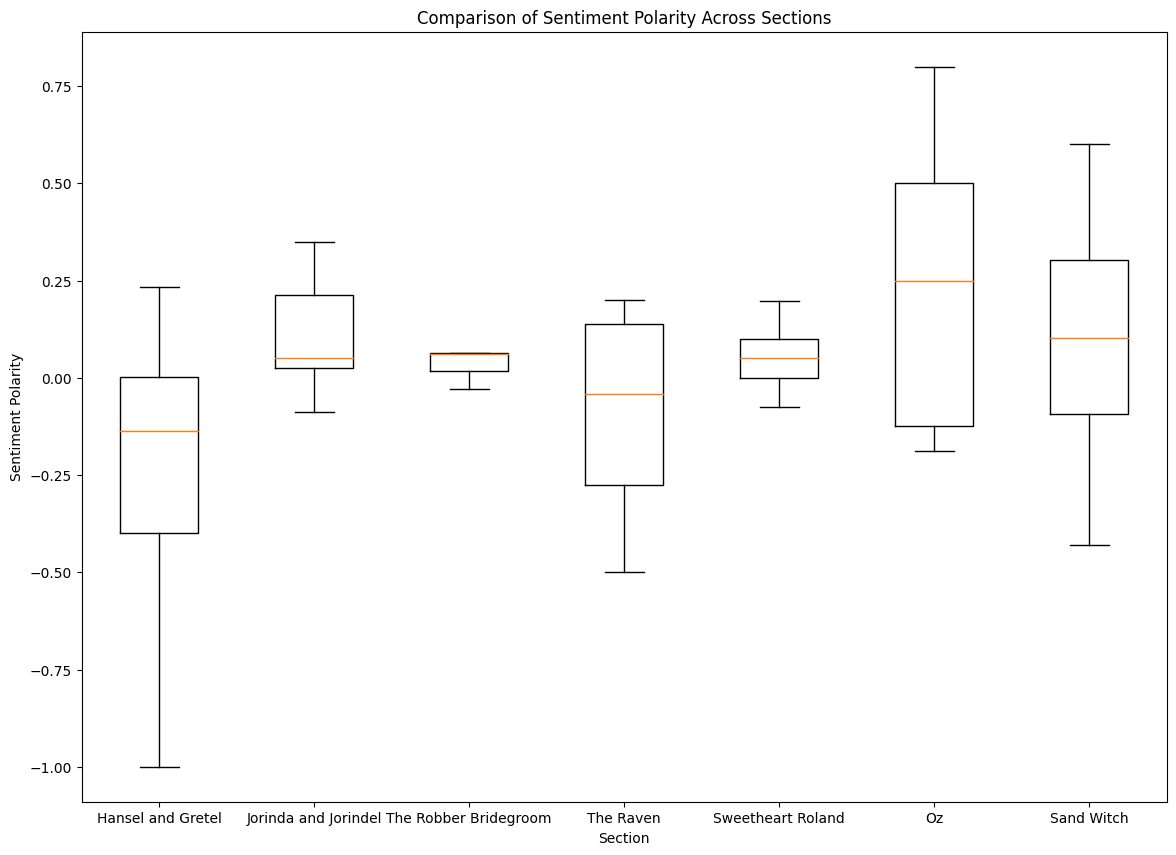

In [160]:
sentiment_scores_hansel = analyze_sentiment(frases_bruja_hansel)
sentiment_scores_jorinda = analyze_sentiment_j(frases_bruja_jorinda)
sentiment_scores_robber = analyze_sentiment_r(frases_bruja_robber)
sentiment_scores_raven = analyze_sentiment_raven(frases_bruja_raven)
sentiment_scores_sweetheart = analyze_sentiment_sweetheart(frases_bruja_sweetheart)
sentiment_scores_oz = analyze_sentiment(frases_bruja_oz)
sentiment_scores_sandwitch = analyze_sentiment_sandwitch(frases_sandwitch)

section_names = ["Hansel and Gretel", "Jorinda and Jorindel", "The Robber Bridegroom", "The Raven", "Sweetheart Roland", "Oz", "Sand Witch"]


all_sentiment_scores = [
    sentiment_scores_hansel,
    sentiment_scores_jorinda,
    sentiment_scores_robber,
    sentiment_scores_raven,
    sentiment_scores_sweetheart,
    sentiment_scores_sandwitch,
    sentiment_scores_oz
]



plt.figure(figsize=(14, 10))
plt.boxplot(all_sentiment_scores, labels=section_names)
plt.title("Comparison of Sentiment Polarity Across Sections")
plt.xlabel("Section")
plt.ylabel("Sentiment Polarity")
plt.show()